## Assignment 1, Albin Eldstål-Damlin
2020-02-04

### Process
1. Download a 120-day set of raw data from a Bugzilla server, store it as `data_<product>_<n_days>.csv`
2. Extract daily series of base measures using the following measurement methods:
  * __base_new__: The total number of new defects opened
  * __base_resolved__: The total number of defects whose state changed to RESOLVED
  * __base_developers__: The total number of individual developers assigned to base_resolved defects
3. Using these base measures, we can calculate the following derived measures:
  * __der_assigned_developers__: The average number of active developers per day during the most recent 7-day period.
  * __der_resolved_per_devday__: The total number of solved defects per day per developer, on average.
  * __der_predicted_defects__: For each future day, a curve-fit extrapolation of historical days with a 7-day stride. For example, next monday is predicted using base_new of preceding mondays. The curve extrapolates to a prediction of the expected number of new defects.
  The reasoning behind this measurement function is that there is a strong correlation between the weekly cycle and the defect activity. See the visualization of the base measures below.
4. The derived measures can be combined, by the following analysis model:
```
needed_developers = sum(der_predicted_defects(PREDICT_DAYS))  / (der_resolved_per_devday * PREDICT_DAYS)
```
which yields an estimate of the number of developer resources needed during the period of PREDICT_DAYS which begins tomorrow.
5. By comparing this with __der_assigned_developers__, we get an indication of whether the current resource allocation is sufficient:
   * Green: The current number of developers is at least 10% above the expected need
   * Yellow: The current number of developers is within +-10% of the expected need
   * Red: The current number of developers is at least 10% below the expected need
   
   The percentage can be altered by setting `DEVELOPER_COUNT_TOLERANCE`

### Tweaking
If you want to manually tweak the data, run the script once to download a CSV and then edit `data_<product>_<n_days>.csv`.
If you re-run the script, it will reuse the data from disk rather than re-downloading, so your changes will be reflected.
The easiest way to change it is to remove some lines, but you could just as easily replicate entries.
The block labeled `Configuration` contains analysis parameters.

In [1]:
import requests
import os.path
import math
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#####################################
# Configuration
#####################################
HISTORY_DAYS = 120                  # Days of data to download
PREDICT_DAYS = 7                  # Days of future activity to predict
DEVELOPER_COUNT_TOLERANCE = 0.1    # Safety margin for a green indication


# Data sources
# This should work for any Bugzilla server, just change the URL and pick a (case-sensitive) "product" from their data.
# Have a look here for more ideas: https://www.bugzilla.org/installation-list/
BUGZILLA={"url": "https://bugs.webkit.org", "product": "WebKit"}
#BUGZILLA={"url": "https://gcc.gnu.org/bugzilla", "product": "gcc"}
#BUGZILLA={"url": "https://bugzilla.mozilla.org", "product": "Firefox"}

In [3]:
#####################################
# Data Extraction, Storage and Access
#####################################
# RAW_DATA is a pandas dataframe representing a complete table of the data, one row per reported defect.

# Download up-to-date data to local filesystem
def download_csv(filename, bugzilla_url, product, days):
    data_url=bugzilla_url + "/buglist.cgi"
    data_params = {
        #"product": "WebKit",
        "product": product,
        "query_format": "advanced",
        "bug_status": [ "NEW", "ASSIGNED", "REOPENED", "RESOLVED", "CLOSED" ],
        "x_axis_field": "resolution",
        "y_axis_field": "assigned_to",
        "ctype": "csv",
        #"chfield": [ "resolution", "bug_status", "[Bug creation]" ],
        "columnlist": "bug_id,product,component,assigned_to,bug_status,resolution,opendate,changeddate",
        "chfieldto": "Now",
        "chfieldfrom": "-{}d".format(days)
    }
    print("Downloading fresh data to {}".format(filename))
    r = requests.get(data_url, params=data_params)
    with open(filename, "w") as f:
        f.write(r.text)

# Returns a pandas dataframe of the raw source data
def get_data(bugzilla_url, product, days):
    filename = "data_{}_{}.csv".format(product,days)
    
    if not os.path.exists(filename):
        download_csv(filename, bugzilla_url, product, days)
    elif (time.time() - os.path.getmtime(filename)) > 24*3600:
        download_csv(filename, bugzilla_url, product, days)
    else:
        print("Using cached {}".format(filename))
    df = pd.read_csv(filename, header=0, parse_dates=["opendate", "changeddate"])
    return df
    

RAW_DATA = get_data(BUGZILLA["url"], BUGZILLA["product"], HISTORY_DAYS)


Using cached data_WebKit_120.csv


In [4]:
#################################################
# Measurement Methods (generating base measures)
#################################################

# Each of these functions returns a dataframe. The actual measure is the number of data elements in the dataframe.
# I do it this way, so that we can look at the actual data after filtering but before counting.

base_new      = lambda df,ldate,udate: df[  (df["opendate"] >= ldate)
                                        &   (df["opendate"] < udate)
                                         ]

base_resolved = lambda df,ldate,udate: df[  (df["changeddate"] >= ldate)
                                        &   (df["changeddate"] < udate)
                                        #&   (df["assigned_to"] != 'webkit-unassigned')
                                        #&   (df["assigned_to"] != "commit-queue")
                                        &   (df["bug_status"] == 'RESOLVED')
                                         ]

base_developers = lambda df,ldate,udate: pd.DataFrame(df[  (df["changeddate"] >= ldate)
                                               &   (df["changeddate"] < udate)
                                               &   (df["bug_status"] == 'RESOLVED')
                                               #&   (df["assigned_to"] != 'webkit-unassigned')
                                               #&   (df["assigned_to"] != "commit-queue")
                                               ]['assigned_to'].drop_duplicates())



def count(df):
    return len(df.index)

def daily_series(df, method):
    global HISTORY_DAYS
    y = []
    x = []
    for day in range(HISTORY_DAYS):
        startdate = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=(day+1)))
        enddate = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=day))
        y = [ count(method(df,startdate, enddate)) ] + y
        x = [ -day ] + x
    return x,y

In [5]:
print("A random sample of the raw data:")
RAW_DATA.sample(5)

A random sample of the raw data:


,bug_id,product,component,assigned_to,bug_status,resolution,opendate,changeddate
4571,203560,WebKit,JavaScriptCore,webkit-unassigned,RESOLVED,FIXED,2019-10-29 05:06:13,2019-12-02 13:53:28
4172,204924,WebKit,New Bugs,simon.fraser,RESOLVED,FIXED,2019-12-05 15:14:19,2019-12-05 15:30:25
124,171618,WebKit,Tools / Tests,Hironori.Fujii,NEW,---,2017-05-03 14:14:28,2020-02-04 00:22:44
2316,204158,WebKit,WebKit2,cdumez,RESOLVED,FIXED,2019-11-13 07:59:49,2019-11-13 08:16:49
1012,204826,WebKit,SVG,webkit-unassigned,NEW,---,2019-12-03 17:25:00,2019-12-03 17:25:11


In [6]:
print("A random sample of the data backing the base_new metric:")
now = pd.Timestamp(datetime.date.today())
last_week=pd.Timestamp(datetime.date.today() - datetime.timedelta(days=7))
base_new(RAW_DATA, last_week, now).sample(5)

A random sample of the data backing the base_new metric:


,bug_id,product,component,assigned_to,bug_status,resolution,opendate,changeddate
1518,207377,WebKit,WebCore Misc.,webkit-unassigned,NEW,---,2020-02-07 01:51:22,2020-02-08 13:28:12
4283,207490,WebKit,WebCore Misc.,timothy,RESOLVED,FIXED,2020-02-10 11:53:26,2020-02-10 14:40:33
2986,207361,WebKit,Animations,graouts,RESOLVED,FIXED,2020-02-06 15:02:21,2020-02-10 09:24:56
242,207459,WebKit,WebKit Misc.,pvollan,NEW,---,2020-02-10 07:16:21,2020-02-10 15:49:20
1546,207497,WebKit,Web Template Framework,webkit-unassigned,NEW,---,2020-02-10 13:16:35,2020-02-11 22:09:26


In [7]:
print("A random sample of the data backing the base_developers metric:")
base_developers(RAW_DATA, last_week, now).sample(5)


A random sample of the data backing the base_developers metric:


,assigned_to
2733,drousso
3644,peng.liu6
2142,beidson
4206,simon.fraser
3525,megan_gardner


In [8]:
###################################
# Base Measures (as daily series)
###################################

dnx, daily_new = daily_series(RAW_DATA, base_new)

drx, daily_resolved = daily_series(RAW_DATA, base_resolved)

ddx, daily_developers = daily_series(RAW_DATA, base_developers)


Visualization of base measures


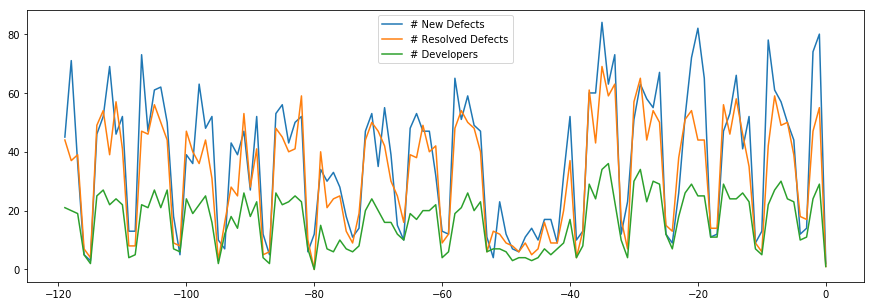

In [9]:
print("Visualization of base measures")
plt.plot(dnx, daily_new, label="# New Defects")
plt.plot(drx, daily_resolved, label="# Resolved Defects")
plt.plot(ddx, daily_developers, label="# Developers")
plt.gcf().set_size_inches(15,5)
_=plt.legend()

In [10]:
#########################################
# Measurement Functions (generating derived measures from base measures)
#########################################

der_assigned_developers = lambda daily_developers: int(np.sum(daily_developers[-1:-8:-1]) / 7)

der_resolved_per_devday = lambda daily_resolved,daily_developers: np.sum(daily_resolved) / np.sum(daily_developers)

def der_predicted_defects(daily_new, predict_days, show=False):
    # 0 is first day after history, 6 is last day of history, etc.
    idx_by_weekday = [None]*7
    hist_by_weekday = [None]*7
    function_by_weekday = [None]*7
    pred_by_weekday = [None]*7
    n_predictions_per_weekday = int(math.ceil(predict_days / 7))
    for wd in range(7):
        start_sample = len(daily_new) - (7 - wd)
        # All the mondays, from oldest to newest
        hist_by_weekday[wd] = list(reversed(daily_new[start_sample:0:-7]))
        idx_by_weekday[wd] = range(-len(hist_by_weekday[wd]),0)
        
        # Find a 3rd degree polynomial that fits this progression
        function_by_weekday[wd] = np.polyfit(idx_by_weekday[wd], hist_by_weekday[wd], deg=3)
        
        # Predict the number of new defects for future mondays
        idx_pred = list(range(0, n_predictions_per_weekday))
        pred_by_weekday[wd] = np.polyval(function_by_weekday[wd], idx_pred)        

    # Interlace the weekday predictions into a sequence of days
    pred_x = list(range(predict_days))
    pred_y = [0] * predict_days
    for i in range(predict_days):
        wd = i % 7
        wdi = int(i / 7)
        pred_y[i] = max(pred_by_weekday[wd][wdi], 0)
    
    # Show the curve-fitting and prediction for one of the weekdays
    if show:
        wd=4
        idx_hist = idx_by_weekday[wd]
        idx_pred = range(-len(hist_by_weekday[wd]),0 + int(predict_days / 7))
        poly = np.polyval(function_by_weekday[wd], idx_pred)
        plt.plot(idx_hist, hist_by_weekday[wd], label="Historic data")
        plt.plot(idx_pred, poly, label="Polynomial prediction")
        plt.legend()
        
    return pred_x,pred_y
    

Predicted new defects for one weekday:


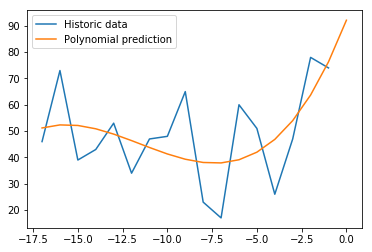

In [11]:
print("Predicted new defects for one weekday:")
_=der_predicted_defects(daily_new, PREDICT_DAYS, show=True)

In [12]:
###################################
# Derived Measures
###################################

assigned_developers = der_assigned_developers(daily_developers)

defs_per_devday = der_resolved_per_devday(daily_resolved, daily_developers)

pnew_x,pnew_y = der_predicted_defects(daily_new, PREDICT_DAYS, show=False)

# of assigned developers per day during the preceding week: 17
# of resolved defects per developer day: 1.9470232088799193
Predicted new defects for 7 days into the future: 327.52941176470625


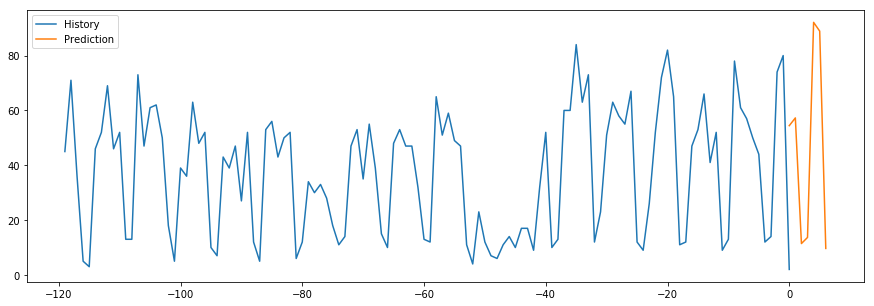

In [13]:
print("# of assigned developers per day during the preceding week: {}".format(assigned_developers))
print("# of resolved defects per developer day: {}".format(defs_per_devday))
print("Predicted new defects for {} days into the future: {}".format(PREDICT_DAYS, np.sum(pnew_y)))
plt.plot(dnx, daily_new, label="History")
plt.plot(pnew_x, pnew_y, label="Prediction")
plt.gcf().set_size_inches(15,5)
_=plt.legend()

In [14]:
###################################
# Analysis Models (indicators from derived measures)
###################################

# Returns (devs_needed,indicator)
# indictator is 'green', 'yellow' or 'red'
def ind_have_enough_devs(expected_defects, defs_per_devday, assigned_developers):
    global DEVELOPER_COUNT_TOLERANCE
    expected_devs_needed = np.sum(expected_defects) / (defs_per_devday * len(expected_defects))
    indicator = 0
    if ( assigned_developers < ((1 - DEVELOPER_COUNT_TOLERANCE) * expected_devs_needed)):
        indicator = 'red'
    elif ( assigned_developers > ((1 + DEVELOPER_COUNT_TOLERANCE) * expected_devs_needed)):
        indicator = 'green'
    else:
        indicator = 'yellow'
    return (expected_devs_needed,indicator)
    
 

In [15]:
###################################
# Indicators
################################### 

expected_need,indicator_color = ind_have_enough_devs(pnew_y, defs_per_devday, assigned_developers)

Expected # of needed developers during the next 7 days: 24.031514238242615


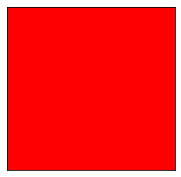

In [16]:

print("Expected # of needed developers during the next {} days: {}".format(PREDICT_DAYS, expected_need))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_facecolor(indicator_color)
